# Providing custom stimuli

Follow this notebook to learn how to use our models for generating hypothesis about neural computations with custom stimuli.

## Example dataset

We take the public [Moving MNIST](https://www.cs.toronto.edu/~nitish/unsupervised_video/) sequence dataset as an example for a custom stimulus dataset.
Moving MNIST consists of short grey-scale videos of numbers from 1-10 which move in arbitrary directions. The dataset entails 10,000 sequences of 20 frames each. Individual frames are 64x64 pixels in height and width.

In [1]:
import torch
import numpy as np
np.random.seed(42)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist

In [2]:
sequences = load_moving_mnist()

In [3]:
# the whole dataset has dims (n_sequences, n_frames, height, width)
sequences.shape

(10000, 20, 64, 64)

In [4]:
example_sequence_ids = np.random.randint(0, high=sequences.shape[1], size=3)

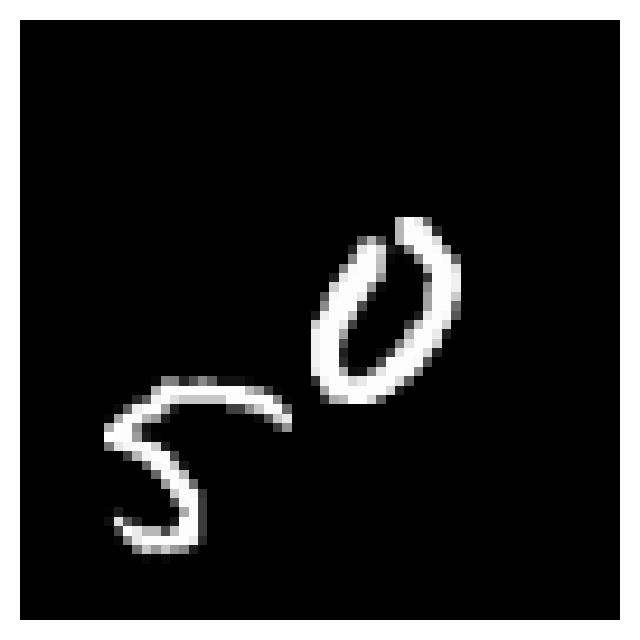

In [5]:
animation = flyvision.animations.Imshow(sequences, cmap=plt.cm.binary_r)
animation.animate_in_notebook(samples=example_sequence_ids)

## BoxEye rendering

##### Rendering cartesian images to hexagonal lattice

We translate cartesian frames into receptor activations by placing simulated photoreceptors in a two-dimensional hexagonal array in pixel space (blue dots below), 31 columns across resulting in 721 columns in total, spaced 13 pixels apart. The transduced luminance at each photoreceptor is the greyscale mean value in the 13×13-pixel region surrounding it (black boxes).

In [1]:
import flyvision

In [2]:
receptors = flyvision.rendering.BoxEye(extent=15, kernel_size=13)

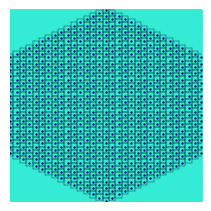

In [3]:
fig = receptors.illustrate()

### Render a single frame

To illustrate, this is what rendering a single frame looks like.

In [1]:
import torch
import numpy as np
np.random.seed(42)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist

In [2]:
sequences = load_moving_mnist()

In [3]:
single_frame = sequences[0, 0]

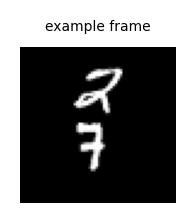

In [4]:
fig, ax = flyvision.plots.plt_utils.init_plot(figsize=[1, 1], fontsize=5)
ax = flyvision.plots.plt_utils.rm_spines(ax)
ax.imshow(single_frame, cmap=plt.cm.binary_r)
_ = ax.set_title('example frame', fontsize=5)

In [5]:
# the rendering uses pytorch native Conv2d module so it can be executed on GPU and fast
# we first move the frame to GPU
single_frame = torch.Tensor(single_frame)

In [6]:
# because the inputs to the receptors instance must have four dimensions (samples, frames, height, width),
# we create two empty dimensions for samples and frames
single_frame = single_frame[None, None]

In [7]:
single_frame.shape

torch.Size([1, 1, 64, 64])

In [8]:
# to render the single frame we simply call the instance
# this automatically rescales the frame to match the receptor layout as illustrated above
# and then places the average pixel value of the 13x13 boxes at the receptor positions
receptors = flyvision.rendering.BoxEye()
rendered = receptors(single_frame)

In [9]:
# the 721 receptor coordinates are implicitly given in the last dimension
# they correspond to sorted hexagonal coordinates (u-coordinate, v-coordinate, value)
rendered.shape

torch.Size([1, 1, 1, 721])

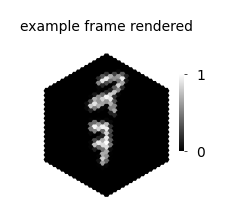

In [10]:
# the rendered frame is a slightly blurred version of the example
fig, ax, _ = flyvision.plots.plots.quick_hex_scatter(
    rendered.squeeze(), vmin=0, vmax=1, cbar_x_offset=0, fontsize=5
)
_ = ax.set_title("example frame rendered", fontsize=5)

In [19]:
# Disclaimer: thinking in hex coordinates can be unfamiliar.
# Therefore, we circumvent dealing with them explicitly.
# Still - to understand how the above plot infers the pixel-plane coordinates 
# from the implicit hexagonal coordinates, you can inspect the following code.

In [20]:
# # we can explicitly create sorted hex-coordinates from the integer radius of the hexagonal grid
# # for a regular hexagonal lattice, the radius is uniquely determined from the number of hexagons

# radius = flyvision.utils.hex_utils.get_hextent(rendered.shape[-1])

# # here we create integer u, v coordinates, and we stick to the same function and convention 
# # everywhere in the code
# u, v = flyvision.utils.hex_utils.get_hex_coords(radius)

# # we transform them to pixel coordinates using our convention
# x, y = flyvision.utils.hex_utils.hex_to_pixel(u, v)

# # and can just scatter them to be back at the photoreceptor layout
# fig, ax = flyvision.plots.plt_utils.init_plot(figsize=[2, 2], fontsize=5)
# ax.scatter(x, y, s=0.5)

## Render a whole dataset to disk

We save rendered sequences to disk to retrieve them faster at runtime.

We will use our library datamate here because it provides a powerful interface for writing and reading arrayfiles.

In [1]:
from typing import List
from tqdm import tqdm
import torch
import numpy as np
np.random.seed(42)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from pathlib import Path
from datamate import root, Directory

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist

In [25]:
# the Directory class is a smart pointer to a specific directory
# on the filesystem

# directory to store the rendered custom stimuli
rendered_data_dest = flyvision.root_dir / "custom_stimuli"


# root tells where the Directory-tree starts
@root(rendered_data_dest)
class RenderedData(Directory):
    class Config(dict):
        extent: int  # radius, in number of receptors of the hexagonal array.
        kernel_size: int  # photon collection radius, in pixels.
        subset_idx: List[int]  # if specified, subset of sequences to render

    def __init__(self, config: Config):
        # here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # this code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = load_moving_mnist()

        # we use the configuration to control the settings under which we render the stimuli
        receptors = flyvision.rendering.BoxEye(
            extent=config.extent, kernel_size=config.kernel_size
        )

        # for memory-friendly rendering we can loop over individual sequences
        # and subsets of the dataset
        rendered_sequences = []
        subset_idx = getattr(config, "subset_idx", []) or list(
            range(sequences.shape[0])
        )
        with tqdm(total=len(subset_idx)) as pbar:
            for index in subset_idx:
                rendered_sequences.append(receptors(sequences[[index]]).cpu().numpy())
                pbar.update()

        # to join individual sequences along their first dimension
        # to obtain (n_sequences, n_frames, 1, receptors.hexals)
        rendered_sequences = np.concatenate(rendered_sequences, axis=0)

        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences

In [27]:
# note, to render the whole dataset provide an empty list for `subset_idx` or delete the key word argument 
moving_mnist_rendered = RenderedData(
    dict(extent=15, kernel_size=13, subset_idx=[0, 1, 2, 3])
)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.07it/s]


In [28]:
# this is how we can retrieve the sequences from the disk into memory
rendered_sequences = moving_mnist_rendered.sequences[:]

In [29]:
rendered_sequences.shape

(4, 20, 1, 721)

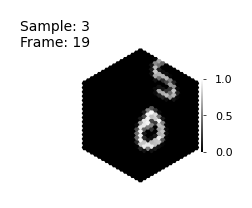

In [30]:
animation = flyvision.animations.HexScatter(rendered_sequences, vmin=0, vmax=1)
animation.animate_in_notebook()

In [30]:
# Note, to delete a Directory, e.g. to change the __init__ and reinstantiate,
# run moving_mnist_rendered.rmtree("y").

## Create a sequence dataset

Next we create a Pytorch dataset for loading the sequences.

In [2]:
from typing import List
from tqdm import tqdm
import torch
import numpy as np
np.random.seed(42)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from pathlib import Path
from datamate import root, Directory

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist
from flyvision.datasets.base import SequenceDataset

In [3]:
# the Directory class is a smart pointer to a specific directory
# on the filesystem

# directory to store the rendered custom stimuli
rendered_data_dest = flyvision.root_dir / "custom_stimuli"


# root tells where the Directory-tree starts
@root(rendered_data_dest)
class RenderedData(Directory):
    class Config(dict):
        extent: int  # radius, in number of receptors of the hexagonal array.
        kernel_size: int  # photon collection radius, in pixels.
        subset_idx: List[int]  # if specified, subset of sequences to render

    def __init__(self, config: Config):
        # here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # this code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = load_moving_mnist()

        # we use the configuration to control the settings under which we render the stimuli
        receptors = flyvision.rendering.BoxEye(
            extent=config.extent, kernel_size=config.kernel_size
        )

        # for memory-friendly rendering we can loop over individual sequences
        # and subsets of the dataset
        rendered_sequences = []
        subset_idx = getattr(config, "subset_idx", []) or list(
            range(sequences.shape[0])
        )
        with tqdm(total=len(subset_idx)) as pbar:
            for index in subset_idx:
                rendered_sequences.append(receptors(sequences[[index]]).cpu().numpy())
                pbar.update()

        # to join individual sequences along their first dimension
        # to obtain (n_sequences, n_frames, 1, receptors.hexals)
        rendered_sequences = np.concatenate(rendered_sequences, axis=0)

        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences

We create a generic interface for custom datasets to make dataloading consistent---this interface can tell the sampler what the framerate, the integration time steps, durations for pre-, and post grey-scale stimulation, and the number of sequences are.

In this case, we inherit a SequenceDataset, that also obeys (and extends) the interface of Pytorch's Dataset.

In [4]:
class CustomStimuli(SequenceDataset):
    
    # implementing the SequenceDataset interface 
    dt = 1/100
    framerate = 24
    t_pre = 0.5
    t_post = 0.5
    n_sequences = None
    augment = False
    
    def __init__(self, rendered_data_config: dict):
        self.dir = RenderedData(rendered_data_config)
        self.sequences = torch.Tensor(self.dir.sequences[:])
        self.n_sequences = self.sequences.shape[0]

    def get_item(self, key):
        sequence = self.sequences[key]
        # to match the framerate to the integration time dt, we can resample frames
        # from these indices. note, when dt = 1/framerate, this will return the exact sequence
        resample = self.get_temporal_sample_indices(sequence.shape[0], sequence.shape[0])
        return sequence[resample]

In [5]:
# note, to render the whole dataset provide an empty list for `subset_idx` or delete the key word argument 
data = CustomStimuli(dict(extent=15, kernel_size=13, subset_idx=[0, 1, 2, 3]))

In [6]:
data[0].shape

torch.Size([84, 1, 721])

<IPython.core.display.Javascript object>


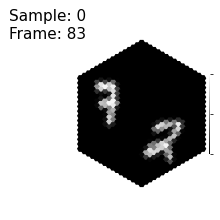

In [7]:
animation = flyvision.animations.HexScatter(data[0][None], vmin=0, vmax=1)
animation.animate_in_notebook()

## Compute model responses to custom stimuli

Now, we can compute model responses across individual models or the whole ensemble to our custom stimulus.

In [3]:
from typing import List
from tqdm import tqdm
import torch
import numpy as np
np.random.seed(42)
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from pathlib import Path
from datamate import root, Directory

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist
from flyvision.datasets.base import SequenceDataset
from flyvision.utils.activity_utils import LayerActivity
from flyvision.animations import StimulusResponse

In [5]:
# the Directory class is a smart pointer to a specific directory
# on the filesystem

# directory to store the rendered custom stimuli
rendered_data_dest = flyvision.root_dir / "custom_stimuli"


# root tells where the Directory-tree starts
@root(rendered_data_dest)
class RenderedData(Directory):
    class Config(dict):
        extent: int  # radius, in number of receptors of the hexagonal array.
        kernel_size: int  # photon collection radius, in pixels.
        subset_idx: List[int]  # if specified, subset of sequences to render

    def __init__(self, config: Config):
        # here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # this code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = load_moving_mnist()

        # we use the configuration to control the settings under which we render the stimuli
        receptors = flyvision.rendering.BoxEye(
            extent=config.extent, kernel_size=config.kernel_size
        )

        # for memory-friendly rendering we can loop over individual sequences
        # and subsets of the dataset
        rendered_sequences = []
        subset_idx = getattr(config, "subset_idx", []) or list(
            range(sequences.shape[0])
        )
        with tqdm(total=len(subset_idx)) as pbar:
            for index in subset_idx:
                rendered_sequences.append(receptors(sequences[[index]]).cpu().numpy())
                pbar.update()

        # to join individual sequences along their first dimension
        # to obtain (n_sequences, n_frames, 1, receptors.hexals)
        rendered_sequences = np.concatenate(rendered_sequences, axis=0)

        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences

In [6]:
class CustomStimuli(SequenceDataset):
    
    # implementing the SequenceDataset interface 
    dt = 1/100
    framerate = 24
    t_pre = 0.5
    t_post = 0.5
    n_sequences = None
    augment = False
    
    def __init__(self, rendered_data_config: dict):
        self.dir = RenderedData(rendered_data_config)
        self.sequences = torch.Tensor(self.dir.sequences[:])
        self.n_sequences = self.sequences.shape[0]

    def get_item(self, key):
        sequence = self.sequences[key]
        # to match the framerate to the integration time dt, we can resample frames
        # from these indices. note, when dt = 1/framerate, this will return the exact sequence
        resample = self.get_temporal_sample_indices(sequence.shape[0], sequence.shape[0])
        return sequence[resample]

In [7]:
# note, to render the whole dataset provide an empty list for `subset_idx` or delete the key word argument 
data = CustomStimuli(dict(extent=15, kernel_size=13, subset_idx=[0, 1, 2, 3]))

To select a network from the ensemble of 50 pretrained networks, let's see what our options are.

Paths to pretrained models from the ensemble end with four digit numbers which are sorted by task error (0-49 from best to worst).

In [8]:
sorted(
    [
        p.relative_to(flyvision.results_dir)
        for p in (flyvision.results_dir / "opticflow/000").iterdir()
        if p.name.isnumeric()
    ]
)

[PosixPath('opticflow/000/0000'),
 PosixPath('opticflow/000/0001'),
 PosixPath('opticflow/000/0002'),
 PosixPath('opticflow/000/0003'),
 PosixPath('opticflow/000/0004'),
 PosixPath('opticflow/000/0005'),
 PosixPath('opticflow/000/0006'),
 PosixPath('opticflow/000/0007'),
 PosixPath('opticflow/000/0008'),
 PosixPath('opticflow/000/0009'),
 PosixPath('opticflow/000/0010'),
 PosixPath('opticflow/000/0011'),
 PosixPath('opticflow/000/0012'),
 PosixPath('opticflow/000/0013'),
 PosixPath('opticflow/000/0014'),
 PosixPath('opticflow/000/0015'),
 PosixPath('opticflow/000/0016'),
 PosixPath('opticflow/000/0017'),
 PosixPath('opticflow/000/0018'),
 PosixPath('opticflow/000/0019'),
 PosixPath('opticflow/000/0020'),
 PosixPath('opticflow/000/0021'),
 PosixPath('opticflow/000/0022'),
 PosixPath('opticflow/000/0023'),
 PosixPath('opticflow/000/0024'),
 PosixPath('opticflow/000/0025'),
 PosixPath('opticflow/000/0026'),
 PosixPath('opticflow/000/0027'),
 PosixPath('opticflow/000/0028'),
 PosixPath('op

We use the `NetworkView` class to point to a model. This object can implement plots plus methods to initialize network, stimuli etc. 

In [22]:
network_view = flyvision.network.NetworkView(flyvision.results_dir / "opticflow/000/0000")

In [23]:
# to load the Pytorch module with pretrained parameters
network = network_view.init_network(chkpt="best_chkpt")

In [24]:
movie_input = data[0]

In [25]:
movie_input.shape

torch.Size([84, 1, 721])

We initialize the network at a stationary state, to remove transient responses due to stimulus onset from functional stimulus responses like motion detection. The network provides two methods for stationary state computation `network.fade_in_state` and `network.steady_state`. We use `fade_in_state` here, which slowly ramps up
the intensity of the first frame in the sequence to compute a stationary state that minimizes the transient response. The method `steady_state` computes a sequence-independent stationary state by providing a whole-field grey-scale stimulus at medium intensity (but it does not get rid of a transient response).

In [26]:
stationary_state = network.fade_in_state(1.0, data.dt, movie_input[[0]])

A convenient way to obtain network responses is to call `network.simulate`
which calls the forward function of the Pytorch module without tracking gradients
(it provides a simpler interface than `network.forward` because it already maps stimulus to receptors using the `network.stimulus` attribute).

In [14]:
# For analysis, we move the returned tensor to cpu.
responses = network.simulate(movie_input[None], data.dt, initial_state=stationary_state).cpu()

In [15]:
responses.shape

torch.Size([1, 84, 45669])

`LayerActivity` is an interface to the response tensor of 45k cells that allows dict- and attribute-style access to the responses of individual cell types and to the responses of their central cells.

In [16]:
responses = LayerActivity(responses, network.connectome, keepref=True)

In [17]:
cell_type = "T4c"

The stimulus on the left, and the response on the right described by passive point neuron voltage dynamics. Cells depolarize (red) and hyperpolarize (blue) in response to the stimulus. A single "hexal" corresponds to one neuron of the cell type.

<IPython.core.display.Javascript object>


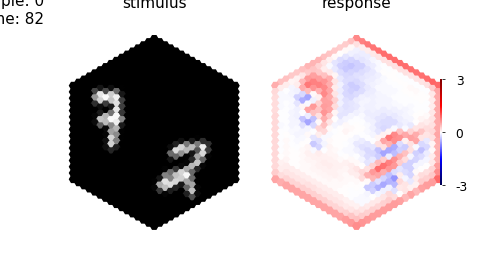

In [18]:
anim = StimulusResponse(
    movie_input[None],
    responses[cell_type][:, :, None]
)
anim.animate_in_notebook(frames=np.arange(anim.frames)[::2])

Often, we are interested in a canonical response of a specific cell type to a specific stimulus to generate hypothesis for their role in a computation. In our model, we can take the central cell as a proxy for all cells of the given type, because cells share their parameters and in- and output connections. I.e. the responses of all cells of a given type are the same (not taking boundary effects into account) when the same stimulus would cross their identical but spatially offset receptive field in the same way.

In [19]:
n_frames = movie_input.shape[0]
time = np.arange(0, n_frames * data.dt, data.dt)

<IPython.core.display.Javascript object>


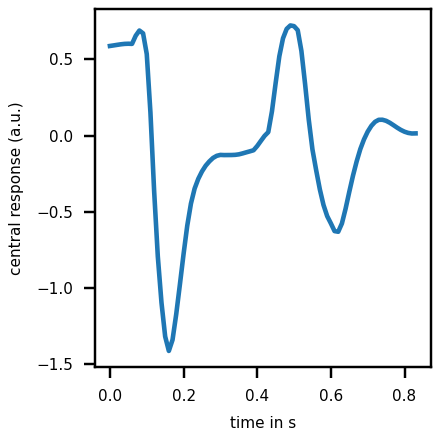

Text(0, 0.5, 'central response (a.u.)')

In [21]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
ax.plot(time, responses.central[cell_type].squeeze())
ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("central response (a.u.)", fontsize=5)

## Compute responses over the whole ensemble

In addition to looking at individual models, we next compute responses across the whole ensemble at once to look at them jointly.

In [1]:
from typing import List
from tqdm import tqdm
import torch
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from pathlib import Path
from datamate import root, Directory

import flyvision
from flyvision.utils.dataset_utils import load_moving_mnist
from flyvision.datasets.base import SequenceDataset
from flyvision.utils.activity_utils import LayerActivity
from flyvision.animations import StimulusResponse
from flyvision.ensemble import EnsembleView

%load_ext autoreload
%autoreload 2

In [ ]:
# the Directory class is a smart pointer to a specific directory
# on the filesystem

# directory to store the rendered custom stimuli
rendered_data_dest = flyvision.root_dir / "custom_stimuli"


# root tells where the Directory-tree starts
@root(rendered_data_dest)
class RenderedData(Directory):
    class Config(dict):
        extent: int  # radius, in number of receptors of the hexagonal array.
        kernel_size: int  # photon collection radius, in pixels.
        subset_idx: List[int]  # if specified, subset of sequences to render

    def __init__(self, config: Config):
        # here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # this code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = load_moving_mnist()

        # we use the configuration to control the settings under which we render the stimuli
        receptors = flyvision.rendering.BoxEye(
            extent=config.extent, kernel_size=config.kernel_size
        )

        # for memory-friendly rendering we can loop over individual sequences
        # and subsets of the dataset
        rendered_sequences = []
        subset_idx = getattr(config, "subset_idx", []) or list(
            range(sequences.shape[0])
        )
        with tqdm(total=len(subset_idx)) as pbar:
            for index in subset_idx:
                rendered_sequences.append(receptors(sequences[[index]]).cpu().numpy())
                pbar.update()

        # to join individual sequences along their first dimension
        # to obtain (n_sequences, n_frames, 1, receptors.hexals)
        rendered_sequences = np.concatenate(rendered_sequences, axis=0)

        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences

In [ ]:
class CustomStimuli(SequenceDataset):
    
    # implementing the SequenceDataset interface 
    dt = 1/100
    framerate = 24
    t_pre = 0.5
    t_post = 0.5
    n_sequences = None
    augment = False
    
    def __init__(self, rendered_data_config: dict):
        self.dir = RenderedData(rendered_data_config)
        self.sequences = torch.Tensor(self.dir.sequences[:])
        self.n_sequences = self.sequences.shape[0]

    def get_item(self, key):
        sequence = self.sequences[key]
        # to match the framerate to the integration time dt, we can resample frames
        # from these indices. note, when dt = 1/framerate, this will return the exact sequence
        resample = self.get_temporal_sample_indices(sequence.shape[0], sequence.shape[0])
        return sequence[resample]

In [ ]:
# note, to render the whole dataset provide an empty list for `subset_idx` or delete the key word argument 
data = CustomStimuli(dict(extent=15, kernel_size=13, subset_idx=[0, 1, 2, 3]))

Similar to the `NetworkView` object, the `EnsembleView` object points to an ensemble and implements plots plus methods to initialize networks, stimuli etc. This object provides dict- and attribute-style access to individual `NetworkView` instances.

In [2]:
ensemble = EnsembleView(flyvision.results_dir / "opticflow/000")

In [8]:
movie_input = data[0]

`ensemble.simulate` provides an efficient method to return responses of all networks within the ensemble.

In [9]:
# ensemble.simulate returns an iterator over `network.simulate` for each network.
# we exhaust it and stack responses from all models in the first dimension
responses = np.array(list(ensemble.simulate(movie_input[None], data.dt, fade_in=True)))

In [10]:
# dims are (n_models, n_sequences, n_frames, n_cells)
responses.shape

[autoreload of flyvision.ensemble failed: Traceback (most recent call last):
  File "/Users/lappalainenj/mambaforge-pypy3/envs/flyvision/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/lappalainenj/mambaforge-pypy3/envs/flyvision/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/lappalainenj/mambaforge-pypy3/envs/flyvision/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/lappalainenj/projects/flyvision/

(50, 1, 84, 45669)

(50, 1, 84, 45669)

In [11]:
responses = LayerActivity(responses, ensemble[0].connectome, keepref=True)

We look at responses of all cells of a specific cell-type in the hexagonal lattice.

In [ ]:
cell_type = "T4c"

# (n_models, n_sequences, n_frames, n_hexals)
responses[cell_type].shape

We can look at all model responses in succession to see how the stimulus causes depolarization and hyperpolarization in the cells. To speed this up a bit, we specify `frames` to look at every tenth frame.

In [2]:
anim = flyvision.animations.activations.StimulusResponse(
    movie_input[None],
    responses[cell_type][:, 0, :, None]
)
anim.animate_in_notebook(frames=np.arange(anim.frames)[::10])

NameError: name 'movie_input' is not defined

Or specify subsets in following (`model_idx`) to look at responses in multiple models jointly. 
Disclaimer: including more axes slows down the animation.

<IPython.core.display.Javascript object>


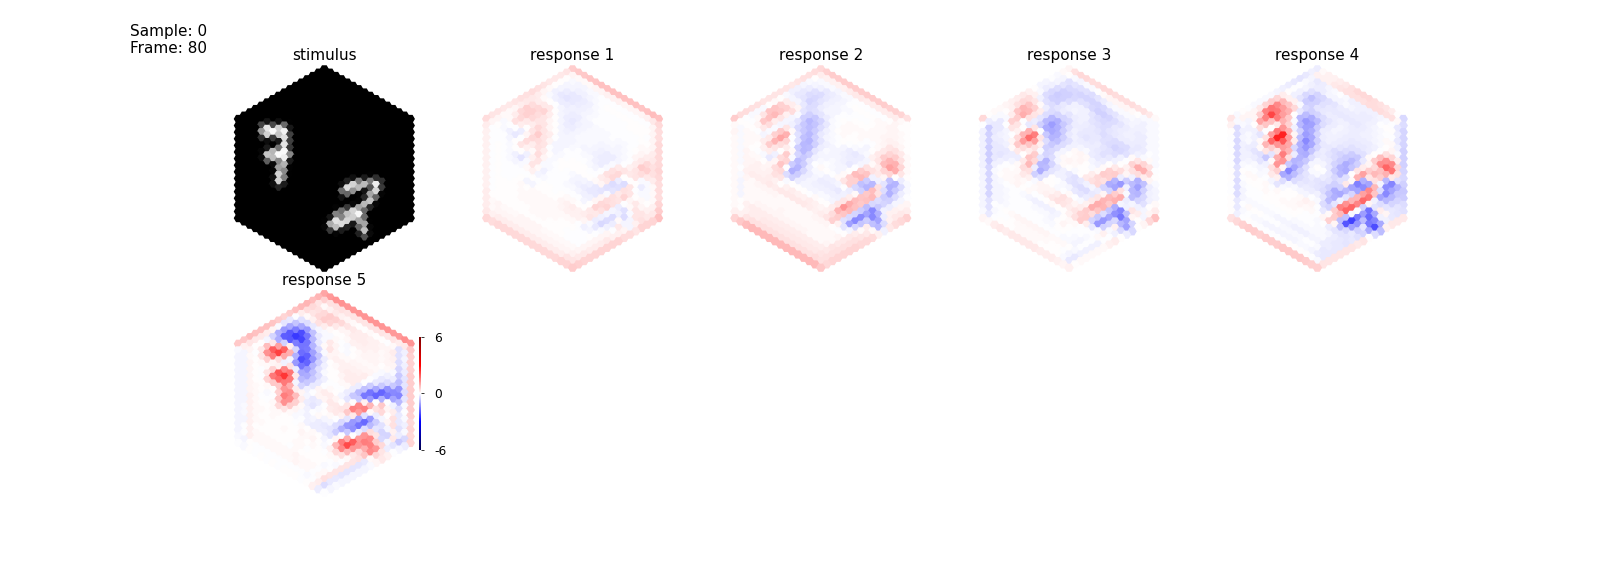

In [19]:
cell_type_responses = responses[cell_type]
model_idx = [0, 1, 2, 3, 4]
anim = flyvision.animations.activations.StimulusResponse(
    movie_input[None],
    [cell_type_responses[i][None, 0, :, None] for i in model_idx]
)
anim.animate_in_notebook(frames=np.arange(anim.frames)[::10])

Often, we are interested in a canonical response of a specific cell type to a specific stimulus to generate hypothesis for their role in a computation. In our model, we can take the central cell as a proxy for all cells of the given type, because cells share their parameters and in- and output connections. I.e. the responses of all cells of a given type are the same (not taking boundary effects into account) when the same stimulus would cross their identical but spatially offset receptive field in the same way.

Let's look at how the whole ensemble characterizes the central cell responses.

In [14]:
central_responses = responses.central

In [15]:
n_frames = movie_input.shape[0]
time = np.arange(0, n_frames * data.dt, data.dt)

In [16]:
colors = ensemble.task_error().colors

<IPython.core.display.Javascript object>


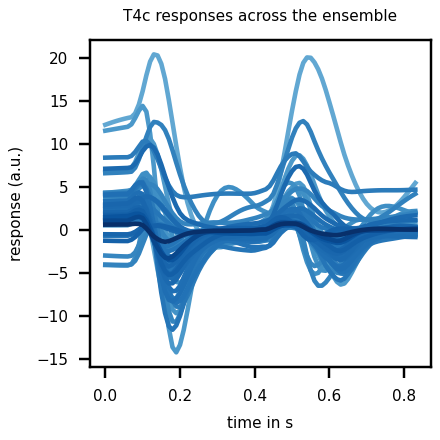

Text(0.5, 1.0, 'T4c responses across the ensemble')

In [17]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
for model_id, response in enumerate(central_responses[cell_type]):
    ax.plot(time, response.squeeze(), c=colors[model_id], zorder=len(ensemble) - model_id)
ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("response (a.u.)", fontsize=5)
ax.set_title(f"{cell_type} responses across the ensemble", fontsize=5)

From the above plot it seems like different models generate different predictions for the cell type function and its hard to tell them apart. Therefore, we clustered the models such that we can separate the above responses by functional cluster for a specific cell type. Note, clusters are stored as dictionaries with key the cluster identity and their values indices to the corresponding models.

In [13]:
cluster_indices = ensemble.cluster_indices(cell_type)
cluster_indices

In [23]:
for cluster_id, model_idx in cluster_indices.items():
    fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
    for model_id in model_idx:
        response = responses.central[cell_type][model_id]
        ax.plot(time, response.squeeze(), c=colors[model_id], zorder=len(ensemble) - model_id)
    ax.set_xlabel("time in s", fontsize=5)
    ax.set_ylabel("response (a.u.)", fontsize=5)
    ax.set_title(f"{cell_type} responses across cluster {cluster_id+1}", fontsize=5)
    plt.show()

For T4c, we know that one set of models is upwards tuning for T4c and one is downwards tuning -- lets observe that.
We choose the best upwards tuning model response and the best downwards tuning model response to compare them.
Notice for vertical movement, how cells in the first model (ON-motion upwards tuning) hyperpolarize at the position corresponding to the bottom of the white edges and depolarize at the position corresponding to the top.
In the second model, the opposite happens. 

In [103]:
cell_type = "T4c"

In [24]:
cluster_indices = ensemble.cluster_indices(cell_type)

In [25]:
anim = flyvision.animations.activations.StimulusResponse(
    movie_input[None],
    [responses[cell_type][[cluster_indices[0][0]], 0][:, :, None], 
     responses[cell_type][[cluster_indices[1][0]], 0][:, :, None]]
)
anim.animate_in_notebook(frames = np.arange(anim.frames)[::10])

# Different example: random walk of blocks
If you want try getting responses to the ad-hoc dataset below.

In [ ]:
from flyvision.utils.dataset_utils import load_moving_mnist